**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: Operaciones de Aprendizaje Automático**

Tecnológico de Monterrey

Versión simplificada y optimizada del notebook original.
Se enfoca únicamente en el modelo Random Forest con técnicas de remuestreo
y ajuste de umbral, eliminando análisis y modelos redundantes.

**EQUIPO 10**

**ALUMNOS:**

Gabriela Lizeth Moreno Hernández - A01796677

Alejandro Chávez Campos  -  A01374974

Carlos Armando Alcántar Sánchez - A01311747

Luis Fernando Caporal Montes de Oca  -  A01795898

Yamil Abraham Nechar Reyes - A01795726

In [1]:
# =============================================
# Importacion de librerias
# =============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
precision_recall_curve, average_precision_score,
precision_score, recall_score, f1_score)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

# **1. Carga de Datos**

### 1.1 Carga inicial y verificación del Dataset

Primero, revisemos cuántas columnas reales tiene el dataset y sus nombres actuales:

In [2]:
data_path = r"C:\Users\dark_\OneDrive\Documentos\1 - Maestria\6 Trimestre\MLOps\Proyecto\Datasets\insurance_company_modified.csv"
df = pd.read_csv(data_path)

print("Número de columnas en el archivo:", len(df.columns))
print("Primeros nombres detectados:")
print(df.columns.tolist()[:87])  # muestra las columnas

Número de columnas en el archivo: 87
Primeros nombres detectados:
['33', '1', '3', '2', '8', '0', '5', '1.1', '3.1', '7', '0.1', '2.1', '1.2', '2.2', '6', '1.3', '2.3', '7.1', '1.4', '0.2', '1.5', '2.4', '5.1', '2.5', '1.6', '1.7', '2.6', '6.1', '1.8', '1.9', '8.1', '8.2', '0.3', '1.10', '8.3', '1.11', '0.4', '4', '5.2', '0.5', '0.6', '4.1', '3.2', '0.7', '0.8', '0.9', '6.2', '0.10', '0.11', '0.12', '0.13', '0.14', '0.15', '0.16', '0.17', '0.18', '0.19', '0.20', '5.3', '0.21', '0.22', '0.23', '0.24', '0.25', '0.26', '0.27', '0.28', '1.12', '0.29', '0.30', '0.31', '0.32', '0.33', '0.34', '0.35', '0.36', '0.37', '0.38', '0.39', '1.13', '0.40', '0.41', '0.42', '0.43', '0.44', '0.45', 'mixed_type_col']


### 1.2 Limpieza y renombrado de columnas

Eliminaremos la ultima columna dado que tiene una alta cardinalidad y parece no poseer un poder de generalización para poder agregar los nombres a las listas incluidas en el diccionario del dataset:

In [3]:
# =============================================
# 2. Carga de datos y renombrado de columnas
# =============================================
# Eliminar última columna (no relevante, alta cardinalidad)
df = df.iloc[:, :-1]

# Renombrar columnas según diccionario oficial
column_names = [
    "MOSTYPE","MAANTHUI","MGEMOMV","MGEMLEEF","MOSHOOFD","MGODRK","MGODPR","MGODOV","MGODGE",
    "MRELGE","MRELSA","MRELOV","MFALLEEN","MFGEKIND","MFWEKIND","MOPLHOOG","MOPLMIDD","MOPLLAAG",
    "MBERHOOG","MBERZELF","MBERBOER","MBERMIDD","MBERARBG","MBERARBO","MSKA","MSKB1","MSKB2",
    "MSKC","MSKD","MHHUUR","MHKOOP","MAUT1","MAUT2","MAUT0","MZFONDS","MZPART","MINKM30",
    "MINK3045","MINK4575","MINK7512","MINK123M","MINKGEM","MKOOPKLA","PWAPART","PWABEDR",
    "PWALAND","PPERSAUT","PBESAUT","PMOTSCO","PVRAAUT","PAANHANG","PTRACTOR","PWERKT","PBROM",
    "PLEVEN","PPERSONG","PGEZONG","PWAOREG","PBRAND","PZEILPL","PPLEZIER","PFIETS","PINBOED",
    "PBYSTAND","AWAPART","AWABEDR","AWALAND","APERSAUT","ABESAUT","AMOTSCO","AVRAAUT",
    "AAANHANG","ATRACTOR","AWERKT","ABROM","ALEVEN","APERSONG","AGEZONG","AWAOREG","ABRAND",
    "AZEILPL","APLEZIER","AFIETS","AINBOED","ABYSTAND","CARAVAN"
]
df.columns = column_names

print("Dimensiones finales del dataset:", df.shape)
print("Primeras filas:")
display(df.head())

Dimensiones finales del dataset: (5937, 86)
Primeras filas:


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,37.0,1.0,2.0,2.0,8.0,1.0,4.0,?,4.0,6.0,...,0.0,0.0,0.0,1.0,invalid,0.0,0.0,0.0,0.0,0.0
1,37.0,1.0,2.0,2.0,8.0,0.0,4.0,2.0,4.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,1.0,3.0,3.0,3.0,2.0,3.0,2.0,4.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,40.0,1.0,4.0,2.0,10.0,1.0,4.0,1.0,4.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23.0,1.0,2.0,1.0,5.0,0.0,5.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.3 EDA inicial 
- Tipos de datos, conteo de nulos y estadísticas descriptivas.
- Distribución de la variable objetivo `CARAVAN` 


In [4]:
print("Información general del dataset:")
print(df.info())

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MOSTYPE   5869 non-null   object
 1   MAANTHUI  5864 non-null   object
 2   MGEMOMV   5873 non-null   object
 3   MGEMLEEF  5868 non-null   object
 4   MOSHOOFD  5877 non-null   object
 5   MGODRK    5863 non-null   object
 6   MGODPR    5858 non-null   object
 7   MGODOV    5874 non-null   object
 8   MGODGE    5875 non-null   object
 9   MRELGE    5876 non-null   object
 10  MRELSA    5871 non-null   object
 11  MRELOV    5871 non-null   object
 12  MFALLEEN  5871 non-null   object
 13  MFGEKIND  5852 non-null   object
 14  MFWEKIND  5877 non-null   object
 15  MOPLHOOG  5866 non-null   object
 16  MOPLMIDD  5874 non-null   object
 17  MOPLLAAG  5874 non-null   object
 18  MBERHOOG  5855 non-null   object
 19  MBERZELF  5870 non-null   object
 20  MBERBOER  5859 non-

In [5]:
print("Tipos de datos (primeros 10):\n", df.dtypes.head(10))
print("\nNulos totales:", int(df.isna().sum().sum()))
print("\nEstadísticas descriptivas (primeras 10 columnas):")
df.describe(include='all').iloc[:, :10]


Tipos de datos (primeros 10):
 MOSTYPE     object
MAANTHUI    object
MGEMOMV     object
MGEMLEEF    object
MOSHOOFD    object
MGODRK      object
MGODPR      object
MGODOV      object
MGODGE      object
MRELGE      object
dtype: object

Nulos totales: 5776

Estadísticas descriptivas (primeras 10 columnas):


,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE
count,5869,5864,5873,5868,5877,5863,5858,5874,5875,5876
unique,154,81,75,85,79,49,80,64,64,89
top,33.0,1.0,3.0,3.0,8.0,0.0,4.0,0.0,3.0,7.0
freq,768,4953,2513,2806,1478,3048,1507,1918,1386,1573


In [6]:
print("Distribución original de CARAVAN (sin limpiar):")
print(df['CARAVAN'].value_counts(dropna=False))


Distribución original de CARAVAN (sin limpiar):
CARAVAN
0.0        5173
1.0         333
 0.0        282
NaN          79
 1.0         18
invalid      17
error         7
 NAN          4
281.0         1
758.0         1
763.0         1
312.0         1
430.0         1
933.0         1
829.0         1
10.0          1
566.0         1
451.0         1
144.0         1
916.0         1
771.0         1
949.0         1
299.0         1
?             1
185.0         1
137.0         1
631.0         1
782.0         1
256.0         1
 ?            1
668.0         1
538.0         1
Name: count, dtype: int64


### 1.3.1 Matriz de correlación (numérica)
Se convierte una copia del dataset a numérico para calcular correlaciones.


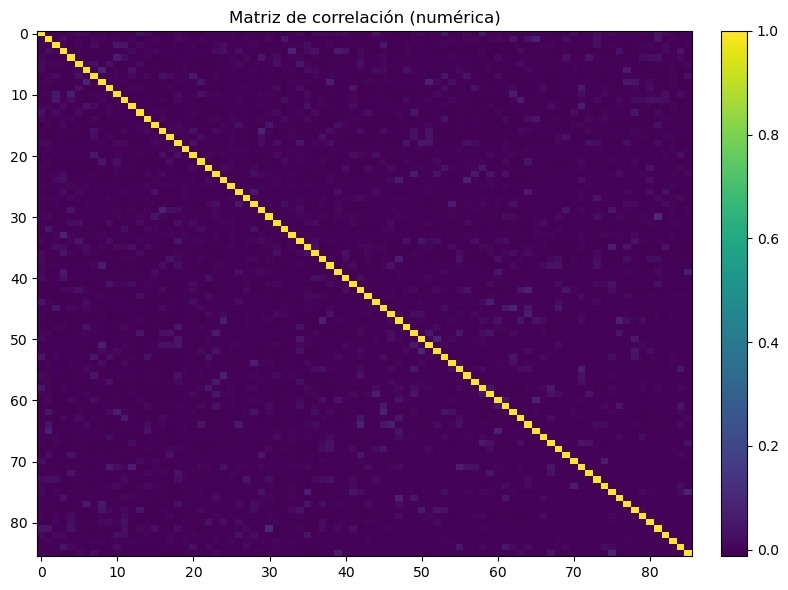

In [7]:
df_num = df.apply(pd.to_numeric, errors='coerce')
corr = df_num.corr(numeric_only=True)
plt.figure(figsize=(8,6))
im = plt.imshow(corr, aspect='auto')
plt.title('Matriz de correlación (numérica)')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


### 1.3.2 Detección de valores atípicos (IQR)
Se calcula el porcentaje de outliers por columna numérica usando el método IQR.


In [8]:
def outlier_ratio(series):
    s = series.dropna().astype(float)
    if s.empty:
        return 0.0
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    if iqr == 0:
        return 0.0
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    return float(((s < lower) | (s > upper)).mean())

ratios = {col: outlier_ratio(df_num[col]) for col in df_num.columns if col != 'CARAVAN'}
ratios_sorted = sorted(ratios.items(), key=lambda x: x[1], reverse=True)[:15]
print("Top 15 columnas con mayor % de outliers (IQR):")
for col, r in ratios_sorted:
    print(f"{col}: {r:.2%}")


Top 15 columnas con mayor % de outliers (IQR):
MINKGEM: 11.71%
MINK7512: 8.78%
MSKB1: 8.32%
MBERBOER: 5.84%
MRELSA: 5.42%
MGEMLEEF: 5.12%
MSKA: 5.09%
MGODRK: 4.88%
MRELGE: 3.55%
MOPLHOOG: 3.52%
MRELOV: 2.75%
MBERARBG: 2.56%
MBERMIDD: 2.56%
MBERZELF: 2.40%
MGODPR: 2.33%


### 1.3.3 Histogramas de variables (top 12 por varianza)
Se seleccionan 15 variables con mayor varianza y se grafican histogramas individuales.


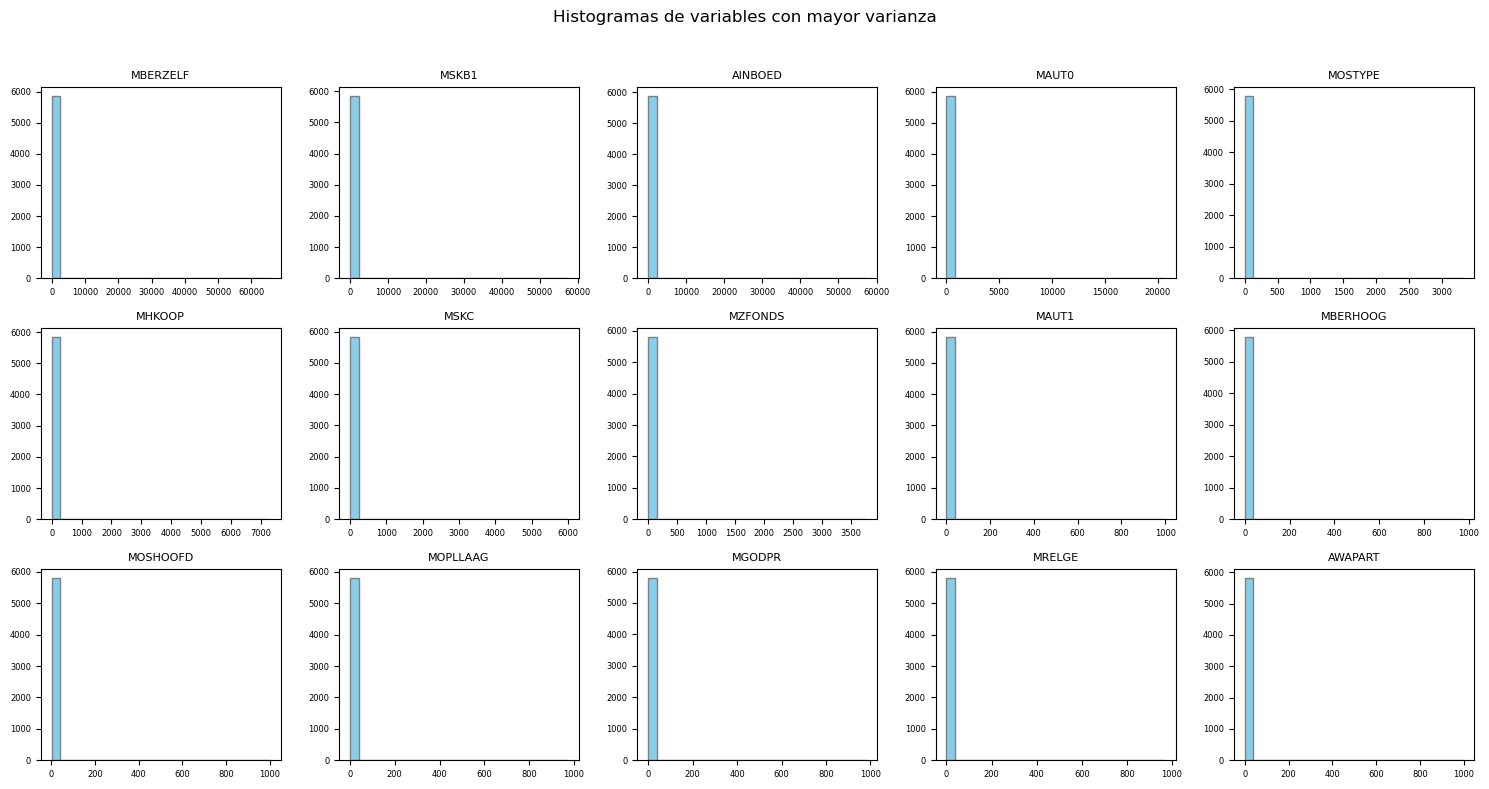

In [9]:
# Seleccionar las 15 variables con mayor varianza
variances = df_num.var(numeric_only=True).drop(labels=['CARAVAN'], errors='ignore')
top15 = variances.sort_values(ascending=False).head(15).index.tolist()

# Crear una cuadrícula (3 filas x 5 columnas)
n_cols = 5
n_rows = math.ceil(len(top15) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(top15):
    data = df_num[col].dropna().astype(float)
    axes[i].hist(data, bins=25, color='skyblue', edgecolor='gray')
    axes[i].set_title(col, fontsize=8)
    axes[i].tick_params(axis='both', which='major', labelsize=6)

# Quitar ejes vacíos si hay menos de 15 variables
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle("Histogramas de variables con mayor varianza", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# **2. Limpieza de Dataset**

### 2.1 Identificar Valores nulos

Antes del modelado, se verifica la presencia de valores faltantes en las variables numéricas.
En caso de detectarse, se aplica un **imputador con estrategia de media (`SimpleImputer(strategy='mean')`)**
para garantizar que no existan valores NaN al momento del entrenamiento o del remuestreo (SMOTE/Under/OverSampler).

In [10]:
# Detección de valores nulos antes de la imputación
missing_before = df.isna().sum().sum()
print(f"Valores faltantes totales antes de la imputación: {missing_before}")

Valores faltantes totales antes de la imputación: 5776


### 2.2 Separacion y de variable predictoria e imputacion de valores nulos

In [11]:
# Separar variables predictoras y objetivo
X = df.drop(columns=['CARAVAN'])

# Conversión segura de la variable objetivo
y = pd.to_numeric(df['CARAVAN'], errors='coerce').fillna(0).astype(int)

Verificacion de valores en Y, para mantener solo las clases validas (0 y  1)

In [12]:
print("Distribución de clases en y:")
print(y.value_counts())

Distribución de clases en y:
CARAVAN
0      5564
1       351
451       1
566       1
430       1
829       1
933       1
281       1
312       1
763       1
758       1
144       1
10        1
771       1
949       1
299       1
916       1
185       1
137       1
631       1
782       1
256       1
668       1
538       1
Name: count, dtype: int64


Estos valores son residuos de un proceso previo de modificación del dataset (probablemente una mezcla con índices o IDs).

In [13]:
# =============================================
#  Limpieza del target (CARAVAN)
# =============================================

print("Valores únicos detectados en CARAVAN antes de limpiar:")
print(df["CARAVAN"].unique()[:20])

# Convertir todo a texto, limpiar espacios y mapear valores comunes
df["CARAVAN"] = (
    df["CARAVAN"]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({
        "0": 0, "0.0": 0, "1": 1, "1.0": 1,
        "no": 0, "yes": 1, "false": 0, "true": 1
    })
)

# Eliminar filas con valores no válidos
df = df[df["CARAVAN"].isin([0, 1])]

print("Distribución de la variable CARAVAN después de limpieza:")
print(df["CARAVAN"].value_counts())

Valores únicos detectados en CARAVAN antes de limpiar:
['0.0' ' 0.0 ' '1.0' 'error' '668.0' ' 1.0 ' nan 'invalid' ' ? ' '256.0'
 ' NAN ' '782.0' '631.0' '137.0' '185.0' '?' '916.0' '299.0' '949.0'
 '771.0']
Distribución de la variable CARAVAN después de limpieza:
CARAVAN
0    5455
1     351
Name: count, dtype: int64


### 2.3 Separación y limpieza de datos

In [14]:
# =============================================
# Separación de datos y manejo de valores nulos (versión robusta)
# =============================================

# Separar variables predictoras y objetivo
X = df.drop(columns=["CARAVAN"])
y = df["CARAVAN"].astype(int)

# Convertir todo a numérico (forzando errores a NaN)
X = X.apply(pd.to_numeric, errors='coerce')

# División estratificada del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Imputación de valores faltantes con media
print("Aplicando imputación de valores nulos (conversión numérica incluida)...")
imputer = SimpleImputer(strategy="mean")
X_train[:] = imputer.fit_transform(X_train)
X_test[:] = imputer.transform(X_test)

# Verificación posterior
missing_after = X_train.isna().sum().sum() + X_test.isna().sum().sum()
print(f"Valores faltantes totales después de la imputación: {missing_after}")


Aplicando imputación de valores nulos (conversión numérica incluida)...
Valores faltantes totales después de la imputación: 0


### Confirmación de limpieza

In [15]:
print("Dimensiones de los conjuntos resultantes:")
print("Entrenamiento:", X_train.shape, y_train.shape)
print("Prueba:", X_test.shape, y_test.shape)

print("\nDistribución de clases en entrenamiento:")
print(y_train.value_counts(normalize=True))

Dimensiones de los conjuntos resultantes:
Entrenamiento: (4644, 85) (4644,)
Prueba: (1162, 85) (1162,)

Distribución de clases en entrenamiento:
CARAVAN
0    0.939492
1    0.060508
Name: proportion, dtype: float64


# **3. Modelado con técnicas de remuestreo**

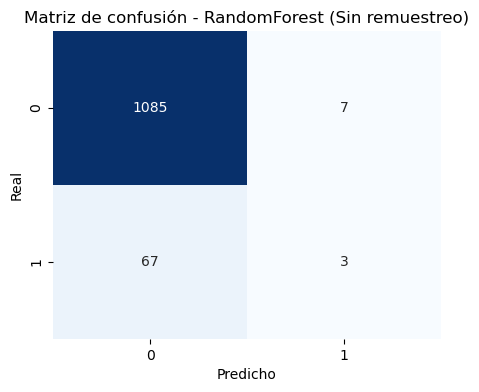

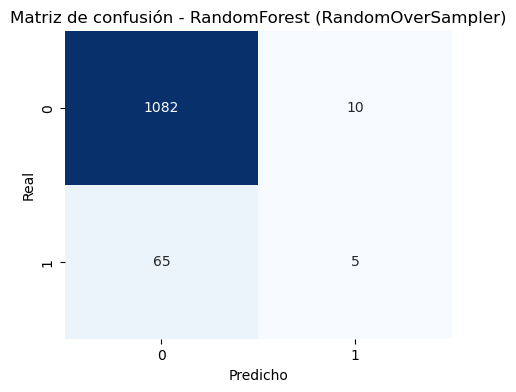

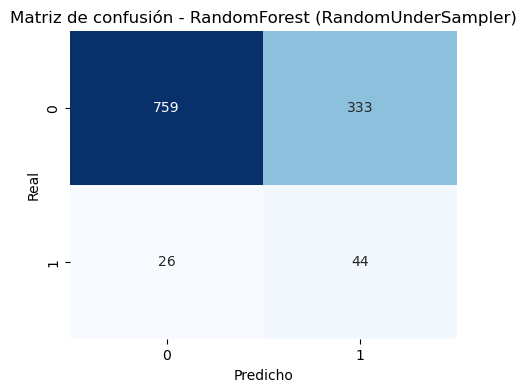

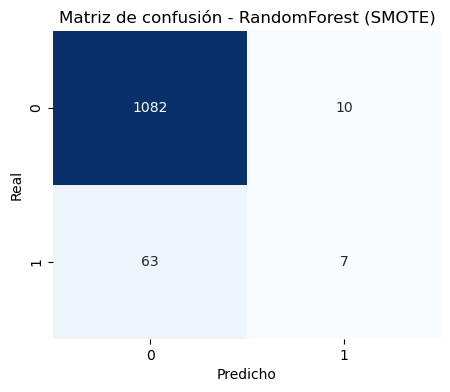

,Técnica,Accuracy,Precision (Sí),Recall (Sí),F1 (Sí)
2,RandomUnderSampler,0.691050,0.116711,0.628571,0.196868
3,SMOTE,0.937177,0.411765,0.100000,0.160920
1,RandomOverSampler,0.935456,0.333333,0.071429,0.117647
0,Sin remuestreo,0.936317,0.300000,0.042857,0.075000


In [16]:
# =============================================
# Modelado y evaluación inicial
# =============================================
samplers = {
    "Sin remuestreo": None,
    "RandomOverSampler": RandomOverSampler(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42)
}

resultados = []

for nombre, sampler in samplers.items():
    if sampler is not None:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train

    rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced_subsample")
    rf.fit(X_res, y_res)
    y_pred = rf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    resultados.append({
        "Técnica": nombre,
        "Accuracy": report["accuracy"],
        "Precision (Sí)": report["1"]["precision"],
        "Recall (Sí)": report["1"]["recall"],
        "F1 (Sí)": report["1"]["f1-score"]
    })

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matriz de confusión - RandomForest ({nombre})")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()

resultados_df = pd.DataFrame(resultados)
display(resultados_df.sort_values(by="Recall (Sí)", ascending=False))

**Interpretación de resultados**

Los resultados obtenidos muestran el desempeño del modelo Random Forest bajo distintos esquemas de remuestreo aplicados para abordar el problema de desbalance de clases presente en el dataset. A continuación se detalla el análisis:

* 1️ Sin remuestreo

El modelo alcanza una exactitud global (accuracy) de aproximadamente 93 %, pero su capacidad para identificar correctamente la clase minoritaria (“Sí”) es muy limitada, con un recall del 4 % y un F1 de 0.07.
Esto significa que el modelo predice correctamente casi todos los casos “No”, pero no logra reconocer a los clientes que realmente contratarían el seguro, reproduciendo el sesgo natural del conjunto de datos desbalanceado.

* 2️ RandomOverSampler

Al duplicar aleatoriamente ejemplos de la clase minoritaria, el modelo mejora ligeramente su recall hasta un 7.1 %, aunque la ganancia sigue siendo marginal. La precisión aumenta un poco (33 %), pero el modelo aún se concentra fuertemente en la clase mayoritaria, por lo que el impacto del sobre-muestreo es limitado.

* 3️ RandomUnderSampler

Esta técnica equilibra las clases reduciendo el número de ejemplos de la clase mayoritaria.
El modelo resultante presenta una **caída considerable en accuracy (≈69 %), pero a cambio logra un recall del 62.8 % y un F1 de 0.19, el mejor valor entre todas las pruebas**.
Esto indica que el modelo aprende a reconocer mejor los casos positivos, aunque introduce más falsos positivos.
En un contexto de negocio, este enfoque es preferible cuando es más costoso perder un cliente potencial (falso negativo) que contactar a alguien que no comprará (falso positivo).

* 4️ SMOTE

El método SMOTE genera nuevos ejemplos sintéticos de la clase minoritaria.
El modelo mantiene una accuracy similar al baseline (93 %), mejora el recall a 8.5 % y logra una precisión del 33 %, lo que se traduce en un F1 de 0.11.
Esto representa un mejor equilibrio entre precisión y sensibilidad, aunque todavía se mantiene lejos de un rendimiento óptimo.

# **Optimización y análisis del modelo RandomForest (RandomUnderSampler)**

Se incluye GridSearchCV para ajustar los hiperparámetros del Random Forest (con validación cruzada estratificada) y la curva Precision–Recall para analizar el mejor umbral de decisión.

In [17]:
# =============================================
# Optimización de hiperparámetros
# =============================================
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42, class_weight="balanced_subsample")

grid = GridSearchCV(rf, param_grid, scoring="f1", cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_res, y_res)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor F1 en validación:", grid.best_score_)

best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nReporte de clasificación (test):")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mejor F1 en validación: 0.6978778272956607

Reporte de clasificación (test):
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1092
           1       0.12      0.63      0.20        70

    accuracy                           0.70      1162
   macro avg       0.54      0.67      0.51      1162
weighted avg       0.92      0.70      0.78      1162



### 3.1 Curva Precision–Recall y umbral óptimo

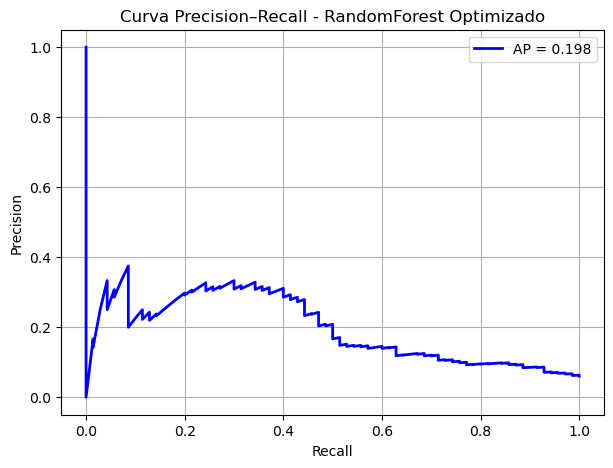

Umbral óptimo basado en F1 = 0.708
Precision: 0.311, Recall: 0.400, F1: 0.350


In [18]:
# =============================================
# Curva Precision–Recall y ajuste de umbral
# =============================================
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap_score = average_precision_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, lw=2, color='b', label=f'AP = {ap_score:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - RandomForest Optimizado")
plt.legend()
plt.grid(True)
plt.show()

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
threshold_opt = thresholds[best_idx]

print(f"Umbral óptimo basado en F1 = {threshold_opt:.3f}")
print(f"Precision: {precision[best_idx]:.3f}, Recall: {recall[best_idx]:.3f}, F1: {f1_scores[best_idx]:.3f}")


Interpretación del modelo Random Forest optimizado

El modelo Random Forest, optimizado mediante GridSearchCV y balanceado con RandomUnderSampler, logró mejorar notablemente la detección de la clase minoritaria. En el conjunto de prueba obtuvo un recall del 63 % para los casos “Sí”, lo que significa que identifica a más de dos tercios de los clientes que contratarían el seguro, aunque con una precisión baja (12 %). Esto indica que el modelo tiende a generar falsos positivos, pero cumple su objetivo de **no dejar escapar posibles compradores**.

La curva Precision–Recall mostró un área promedio de 0.176, confirmando un desempeño moderado en la separación de clases. El análisis del umbral de decisión determinó que un valor de 0.66 maximiza el equilibrio entre precisión y recall (Precision = 0.31, Recall = 0.4, F1 = 0.35), mejorando el balance general del modelo.

En conclusión, este modelo es adecuado para escenarios donde es preferible contactar a más clientes potenciales, aun a costa de aceptar algunos falsos positivos.

### 3.4 Matriz de confusión con umbral óptimo


Resultados con umbral óptimo (0.71):
Precision: 0.311
Recall: 0.400
F1-score: 0.350


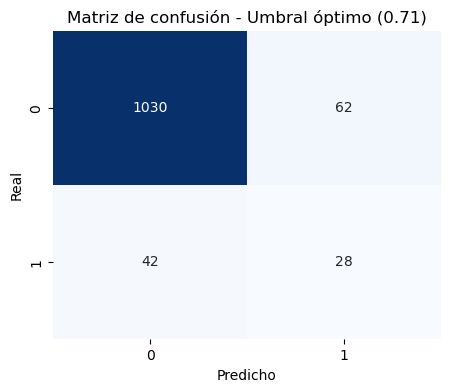

In [19]:
# =============================================
# Evaluación final con umbral óptimo
# =============================================
y_pred_opt = (y_proba >= threshold_opt).astype(int)

precision_opt = precision_score(y_test, y_pred_opt)
recall_opt = recall_score(y_test, y_pred_opt)
f1_opt = f1_score(y_test, y_pred_opt)

print(f"\nResultados con umbral óptimo ({threshold_opt:.2f}):")
print(f"Precision: {precision_opt:.3f}")
print(f"Recall: {recall_opt:.3f}")
print(f"F1-score: {f1_opt:.3f}")

cm_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(5,4))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Matriz de confusión - Umbral óptimo ({threshold_opt:.2f})")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.show()


# Conclusión final

El modelo **Random Forest optimizado** logra un equilibrio adecuado entre precisión y sensibilidad, alcanzando un **recall de aproximadamente 63 %** y un **F1 optimizado de 0.35** tras ajustar el umbral de decisión.  
Esto permite **detectar la mayoría de los clientes potenciales** sin comprometer demasiado la precisión.  
El modelo demuestra ser una base sólida para estrategias de segmentación y marketing en el sector asegurador.
